# Taller DES

**Estudiante:** Omar David Toledo Leguizamón

Previo al taller, instalamos la implementación del algoritmo DES en python para su uso

In [1]:
!pip install pyDes

  Preparing metadata (setup.py) ... done
  Created wheel for pyDes: filename=pyDes-2.0.1-py2.py3-none-any.whl size=9557 sha256=6a5a037bbe5f3d9f474f350df84a55e4e5f62e0bbd927e6298108e73030203f5
  Stored in directory: /root/.cache/pip/wheels/30/04/38/5cb6e4f33d5c481aa1c213e9c1763533e18c717e964bde5bee
Successfully built pyDes


Verificamos las versiones de los paquetes que vamos a usar, que son pyDes y base64

In [2]:
from importlib.metadata import version
import sys

python_version = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
print(f'base64 is part of Python standard library. Python version: {python_version}')
print(f'pyDes package version: {version("pyDes")}')

base64 is part of Python standard library. Python version: 3.10.12
pyDes package version: 2.0.1


Utilizar una implementación del algoritmo DES en cualquier lenguaje de programación (en la página puse un enlace a una implementación en python), en el que se haga lo siguiente:

1. Recibir como entrada cualquier imagen en cualquier formato
2. Convertir la imagen a una representación de bits, por lo que simplemente convierta el archivo que lee en un arreglo de bits.
3. Cifrar la imagen utilizando DES y una clave determinada por usted
4. Codificar el mensaje cifrado en Base64 (en la página del curso hay un enlace a una implementación de Base64 en python)
5. Mostrar en la consola el texto en Base 64
6. Decodificar de Base64 a la representación en bits
7. Decifrar utilizando DES
8. Generar la imagen original y mostrarla

## Desarrollo

En primer lugar, definimos una función que sea capaz de recibir una ruta de un archivo o una ruta en linea para recuperar la imagen a través de http

In [3]:
from io import BytesIO
import requests
from PIL import Image

def loadImage(route,http = False):
    if http:
        r = requests.get(route)
        if r.status_code == 200:
            image = Image.open(BytesIO(r.content))
    else:
        image = Image.open(route)
    return image

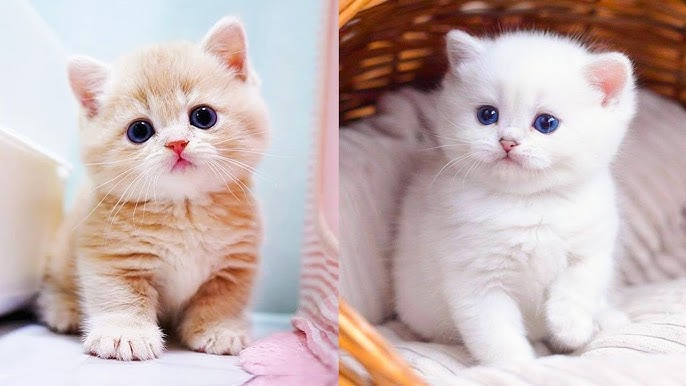

In [4]:
route = 'https://i.ytimg.com/vi/feEMKVcFyC4/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLCRnp5fFToaizxzl2wu9G78jacEjw'
im = loadImage(route,http=True)
im

Ahora, dada una imagen, vamos a convertirla en un objeto de tipo byte para que pueda ser manipulada por el codificador

In [5]:
from io import BytesIO
from PIL import Image

def imageToBytes(im):
    buffer = BytesIO()
    im.save(buffer, format=im.format)
    return buffer.getvalue()

def bytesToImage(byte_data):
    return Image.open(BytesIO(byte_data))

<class 'bytes'>


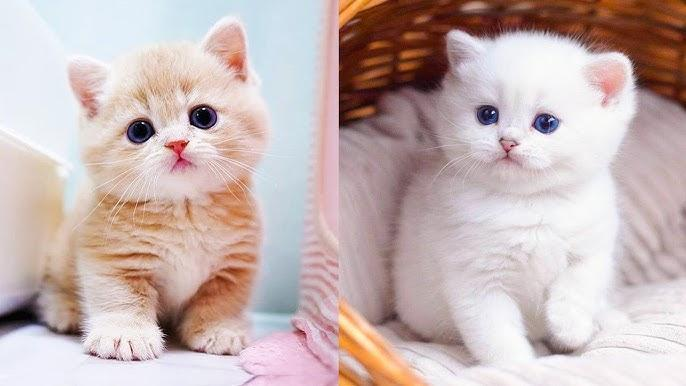

In [6]:
im_byte = imageToBytes(im)
print(type(im_byte))
im_r = bytesToImage(im_byte)
im_r

Se diseñarán las funciones que dada la imagen como un arreglo de bytes, pueda codificarla o decodificarla en base 64

In [7]:
import base64

def imageEncodeBase64(bytes):
    return base64.b64encode(bytes)

def imageDecodeBase64(bytes):
    return base64.b64decode(bytes)

In [8]:
im_byte_b64 = imageEncodeBase64(im_byte)
im_byte_recovered = imageDecodeBase64(im_byte_b64)
assert im_byte_recovered==im_byte

Ahora tomamos la implementación del DES para codificar y decodificar una imagen. Para ello vamos a definir como clave de 8 bytes `b'CRYP2025'`

In [9]:
from pyDes import des, ECB, PAD_PKCS5

key = b'CRYP2025'
k = des(key,ECB,padmode=PAD_PKCS5)

def encryptImage(b):
    global k
    return k.encrypt(b)


def decryptImage(b):
    global k
    return k.decrypt(b)

In [10]:
des_im = encryptImage(im_byte)
rec_im = decryptImage(des_im)
assert im_byte == rec_im

Finalmente, vamos a encadenar el proceso que dada la ruta de una imagen, esta sea cargada, encriptada usando DES y codificada en base 64

In [11]:
from IPython.display import display

def encodeImageB64(route,http=False):
    im = loadImage(route,http=http)
    print(f'Original Image')
    display(im)
    im_byte = imageToBytes(im)
    im_byte_des = encryptImage(im_byte)
    im_byte_des_b64 = imageEncodeBase64(im_byte_des)
    return im_byte_des_b64.decode()

Original Image


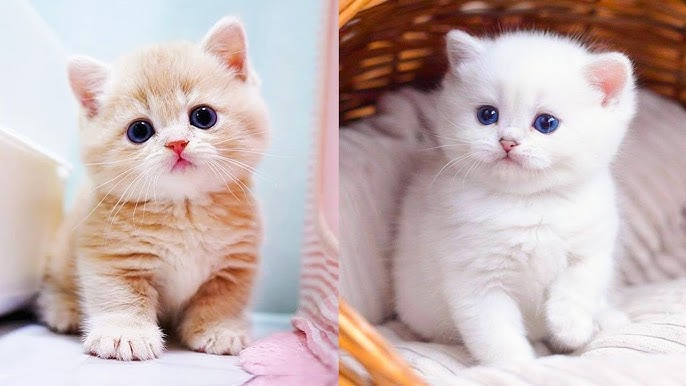

Text in base 64 length: 45728
First 50 characters: 7wwdpGv0nHvdVI3Rsvm61IsODmi7kGpPy5GXtQRjQ5Pht5BPy8


In [12]:
route = 'https://i.ytimg.com/vi/feEMKVcFyC4/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLCRnp5fFToaizxzl2wu9G78jacEjw'
textB64 = encodeImageB64(route,http=True)
print(f'Text in base 64 length: {len(textB64)}\nFirst 50 characters: {textB64[:50]}')

Adicionamente, vamos a encadenar el proceso que hace la decodificación y el desencriptamiento usando DES para recuperar la imagen original

In [13]:
def decodeImageB64(im_byte_des_b64_str,http=False):
    im_byte_des_b64 = im_byte_des_b64_str.encode()
    im_byte_des = imageDecodeBase64(im_byte_des_b64)
    im_byte = decryptImage(im_byte_des)
    im = bytesToImage(im_byte)
    print(f'Recovered Image')
    display(im)
    return im

Recovered Image


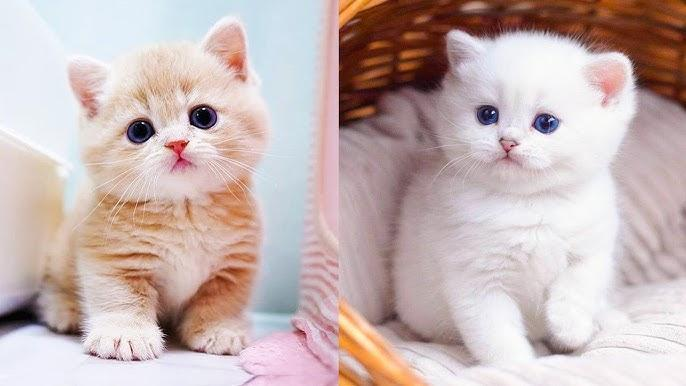

In [14]:
im = decodeImageB64(textB64)

FInalmente unimos todo el proceso en una función principal

In [21]:
def DESMain():
    print('Bienvenido al programa de cifrado de imágenes con DES\n')
    mode = int(input('Elije el modo de operación (1 para cifrar, 2 para descifrar, 3 para salir): '))
    if mode==1:
        route = str(input('Ingresa la ruta de la imagen: '))
        http = True if int(input('Define si la imagen se debe recuperar usando http (1 para si): '))==1 else False
        textB64 = encodeImageB64(route,http)
        print(f'Text in base 64:\n{textB64}')
    elif mode==2:
        text = str(input('Ingresa el texto de la imagen cifrada: '))
        im = decodeImageB64(text)
    else: return
    print()
    DESMain()

[Imagen de prueba](https://images.stockcake.com/public/5/2/a/52aabfd8-a2cf-4644-a18d-085dcc3c6252_medium/intense-cat-gaze-stockcake.jpg)

Bienvenido al programa de cifrado de imágenes con DES

Elije el modo de operación (1 para cifrar, 2 para descifrar, 3 para salir): 1
Ingresa la ruta de la imagen: https://images.stockcake.com/public/5/2/a/52aabfd8-a2cf-4644-a18d-085dcc3c6252_medium/intense-cat-gaze-stockcake.jpg
Define si la imagen se debe recuperar usando http (1 para si): 1
Original Image


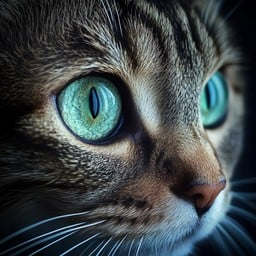

Text in base 64:
7wwdpGv0nHvdVI3Rsvm61IsODmi7kGpPy5GXtQRjQ5Pht5BPy8wxNu8iIFHYobI1xSCiL9Z1LI+TIRsvJI0Qqq4ZEPSP/Vq0dXhan7iKsiYXrKxIc1ViHM2JGizyyUJCRO4GBG6UrqUozeFa6h60qdeWIhmJ+V7K15YiGYn5XsrXliIZifleyteWIhmJ+V7K15YiGYn5Xsq3Hnd5toGgqeEA3gfyH3ZuLues/PZQNMXrGMV/HYueKlNqOFRgPoO3cP1CIKGLqmjNsHdOgwlq9n6MyesmeW4yklCmhYzkPy7qsdde5ORhzp8PSkJoZqXpZ8KiIojSZ3jmYMFS/NGqJoG2MdCa4jk1jwnzE9l1aQabzcwHyO1ONvcNQdYMBFPwOSc4f7GROJjVrwGw/6sb1b8m7CcRfmzfa10L7lYkkjE5OA+0a9dvaAj9RP0XSrf75fsw2uGmJ/sS6efti/zgAjeHbmZBSQ71rETx+f2xOV4XnXyX3NTrs3RYdhPDE9osLk1iJZDOO6vqkT1vQPpoAWHEPEvr6f7m+b0W23qXUpXNsHdOgwlq9s5PlZCcRXSHvekVg4xf0JxV83SDuNOVj8f6DeYOuWkUrAFoMQOgRyw6CnBeKbjTnNpvbJwKVHzNjmzUMIWrPWXybCDuos5FTzsHHpnF7zw2Ozin+rl+WEo2RherXZG1S8PSVxJggVSxaSp0d4awUA7hpafavH3gQBpYdyhLl3CmaeCBYhfEKS5N1GKd6fvVvHsfxt43eaqhUHeJrcLQlkXAGV/yuFYPz0qkZs90M/3bLk1iJZDOO6s+0Tj01ExHcEW/oOXYmREwoe/4rc5hJCsxXUTv9tyyvrgt3lfIVAA+C9V2R7VCmVfRkEJU1/s8096BwYLt5rEKN/4yHIU9iplM1f5af184iYO7Y2jONQm6386EPSad4x6cEgSsE8LyCxoE8iyrFVuQCJwXOtEQrhyHJysUxMCjHXc

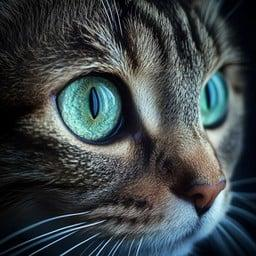


Bienvenido al programa de cifrado de imágenes con DES

Elije el modo de operación (1 para cifrar, 2 para descifrar, 3 para salir): 3


In [22]:
DESMain()